<a href="https://www.kaggle.com/code/melihozcan/a-b-testing-retention-analysis-cookie-cats?scriptVersionId=298062601" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mobile-games-ab-testing-cookie-cats/cookie_cats.csv


# A/B Testing & Retention Analysis: Cookie Cats

## 1. Introduction
**Cookie Cats** is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level.

As players progress through the levels of the game, they will occasionally encounter **gates** that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in an increased and prolonged enjoyment of the game.

### 🔬 The Goal
In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from **level 30** to **level 40**. We will analyze the impact on player retention.

**Specific Question:** Should the gate be at level 30 or level 40?

## 2. Dataset Description
The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

* **`userid`**: A unique number that identifies each player.
* **`version`**: Whether the player was put in the control group (`gate_30` - a gate at level 30) or the group with the moved gate (`gate_40` - a gate at level 40).
* **`sum_gamerounds`**: The number of game rounds played by the player during the first 14 days after install.
* **`retention_1`**: Did the player come back and play **1 day** after installing?
* **`retention_7`**: Did the player come back and play **7 days** after installing?

When a player installed the game, he or she was randomly assigned to either `gate_30` or `gate_40`.

## 3. Data Preparation & Outlier Detection
When we plan to use statistical tests (like t-test or AB-test), the first step is always to check the data distribution and detect outliers. Outliers can skew the results significantly.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv("/kaggle/input/mobile-games-ab-testing-cookie-cats/cookie_cats.csv")

In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [6]:
df[df["sum_gamerounds"]==df["sum_gamerounds"].max()]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


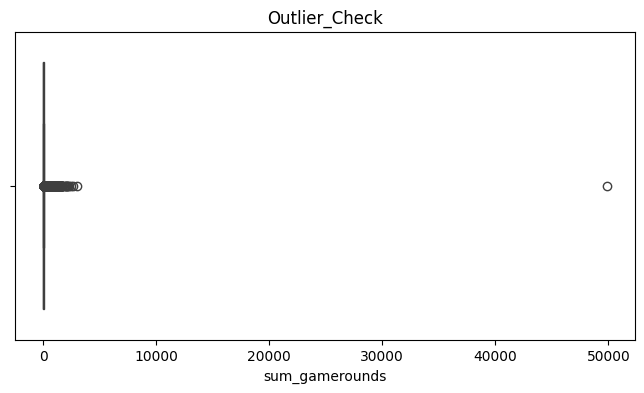

In [7]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df["sum_gamerounds"])
plt.title("Outlier_Check")
plt.show()

In [8]:
df = df[df["sum_gamerounds"] < 40000]

df["sum_gamerounds"].describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

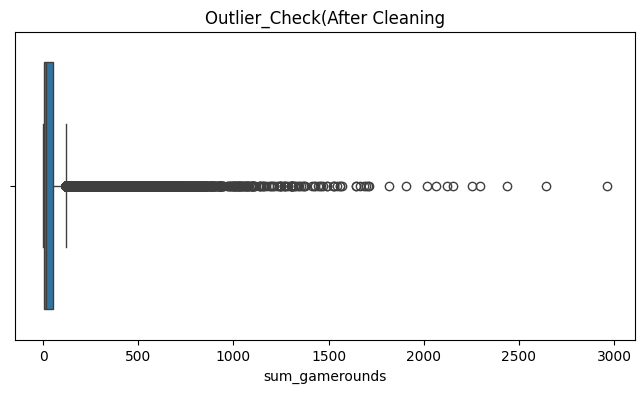

In [9]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df["sum_gamerounds"])
plt.title("Outlier_Check(After Cleaning")
plt.show()

## 4. Exploratory Data Analysis (EDA)
Before jumping into hypothesis testing, we need to understand the distribution of our data.
Most game data follows a **Power Law** distribution (many players play a little, few players play a lot).

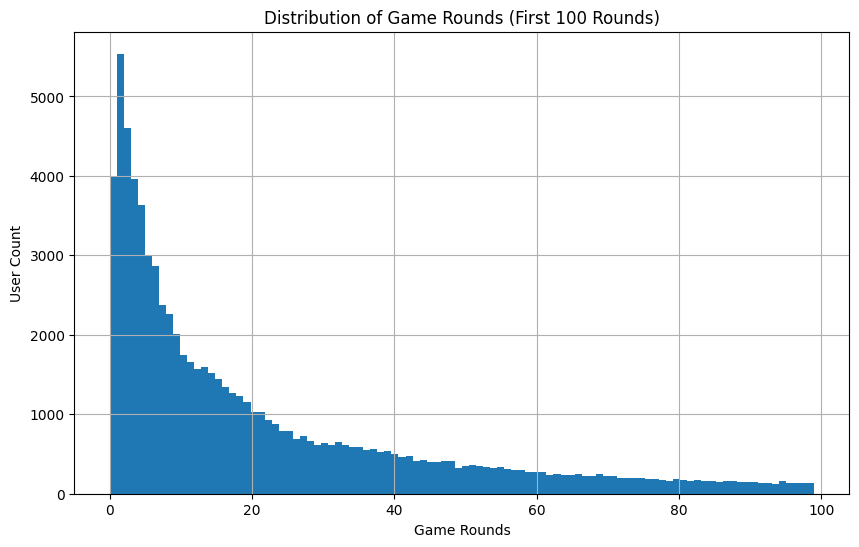

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
df[df.sum_gamerounds < 100].sum_gamerounds.hist(bins=100, ax=ax)
plt.title("Distribution of Game Rounds (First 100 Rounds)")
plt.xlabel("Game Rounds")
plt.ylabel("User Count")
plt.show()

## 5. Statistical Tests
### 5.1. Normality Test (Shapiro-Wilk)
We visually saw that the data is skewed. Now, let's test this statistically using the **Shapiro-Wilk Test**.

* **H0 (Null Hypothesis):** The data follows a normal distribution.
* **H1 (Alternative Hypothesis):** The data does NOT follow a normal distribution.

If p-value < 0.05, we reject H0 (Data is NOT normal).

In [11]:
from scipy.stats import shapiro

# We'll test on the 'gate_30' group
# Shapiro-Wilk test may be too sensitive for large samples
stat, p = shapiro(df[df['version'] == 'gate_30']['sum_gamerounds'])

print(f"Shapiro-Wilk Test P-value: {p}")

alpha = 0.05
if p < alpha:
    print("Result: The data is NOT normally distributed (Reject H0).")
else:
    print("Result: The data is normally distributed (Fail to reject H0).")

Shapiro-Wilk Test P-value: 2.3625307025017602e-139
Result: The data is NOT normally distributed (Reject H0).


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 44699.
  res = hypotest_fun_out(*samples, **kwds)


### 5.2. Hypothesis Testing (Mann-Whitney U)
Since our data is **not normally distributed**, we cannot use the standard T-Test. Instead, we will use the **Mann-Whitney U Test** (a non-parametric test) to compare the `sum_gamerounds` between the two groups.

* **H0:** There is NO difference between the two groups.
* **H1:** There is a difference between the two groups.

In [12]:
from scipy.stats import mannwhitneyu

# Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(df[df['version'] == 'gate_30']['sum_gamerounds'],
                               df[df['version'] == 'gate_40']['sum_gamerounds'])

print(f"Mann-Whitney U Test P-value: {p_value}")

if p_value < 0.05:
    print("Result: Statistically Significant Difference found (Reject H0).")
else:
    print("Result: No Statistically Significant Difference (Fail to reject H0).")

Mann-Whitney U Test P-value: 0.05089155279145376
Result: No Statistically Significant Difference (Fail to reject H0).


In [13]:
df.groupby("version")["userid"].count()

version
gate_30    44699
gate_40    45489
Name: userid, dtype: int64

In [14]:
retention_rates = df.groupby("version")[["retention_1","retention_7"]].mean()
print(retention_rates)

         retention_1  retention_7
version                          
gate_30     0.448198     0.190183
gate_40     0.442283     0.182000


In [15]:
boot_7d = []
for i in range(1000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)

boot_7d = pd.DataFrame(boot_7d)

Text(0.5, 0, 'Retention Rate')

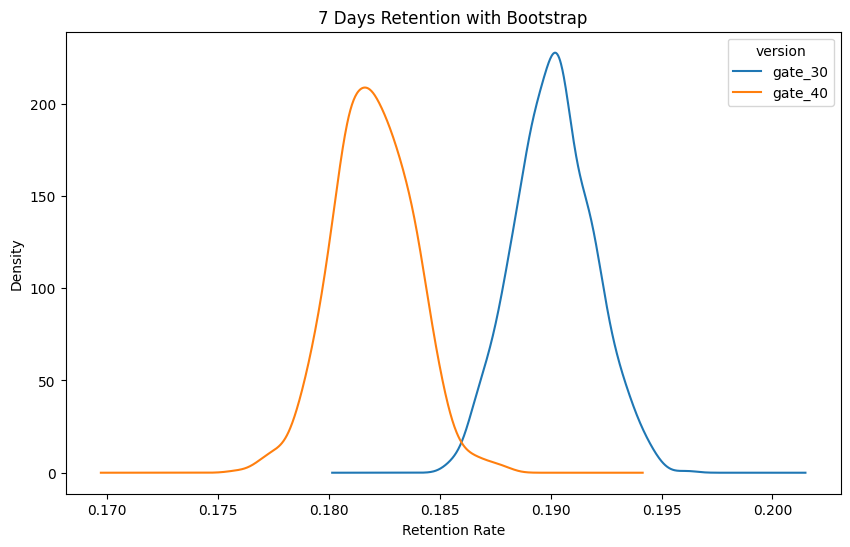

In [16]:
ax = boot_7d.plot(kind='kde', figsize=(10,6))
ax.set_title('7 Days Retention with Bootstrap')
ax.set_xlabel('Retention Rate')

In [17]:
boot_7d["diff"] = (boot_7d["gate_30"] - boot_7d["gate_40"]) / boot_7d["gate_40"] * 100


In [18]:
prob = (boot_7d["diff"] > 0).mean()
print(f"The possibility that Gate30 is better: {prob:.1%}")

The possibility that Gate30 is better: 100.0%


## 6. Conclusion & Recommendation
In this project, we analyzed the results of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40.

### Key Findings:
1.  **Retention:** Moving the gate to level 40 **significantly decreases** 7-day retention. The bootstrap analysis shows with nearly 100% confidence that the 7-day retention is higher when the gate is at level 30.
2.  **Game Rounds:** The Mann-Whitney U test revealed **no statistically significant difference** in the number of game rounds played between the two groups (p-value > 0.05). This suggests that while players are more likely to churn at level 40, those who stay play similar amounts.

### Final Recommendation:
Based on the strong evidence from the retention analysis, we recommend **keeping the gate at Level 30**. Moving it to Level 40 negatively impacts player retention without providing any significant benefit in terms of player engagement.